Found --> /kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Did not find --> /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Rembrandt
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Titian
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Marc_Chagall
Found 3971 images belonging to 11 classes.
Found 3971 images belonging to 11 classes.
Training set shape: (3176, 150528)
Test set shape: 

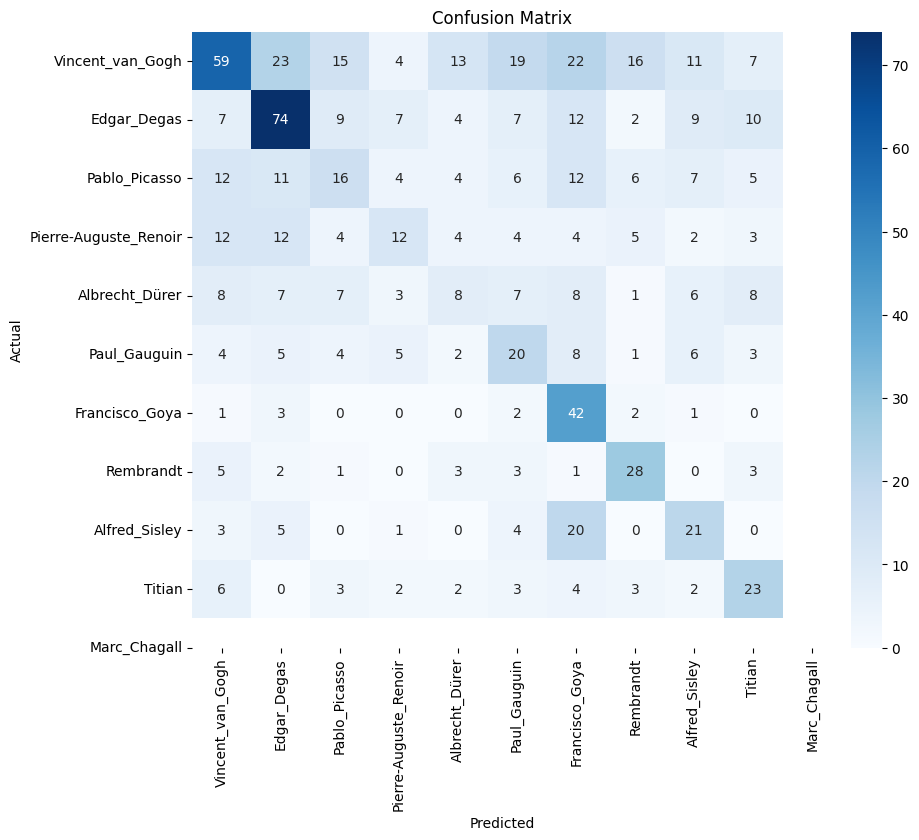

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

#Import artist list csv
artists_path = '/kaggle/input/best-artworks-of-all-time/artists.csv'
artists_df = pd.read_csv(artists_path)

#This is only allowing inclusion of artists with more than 200 works, so that we have enough training data for each 
filtered_artists_df = artists_df[artists_df['paintings'] > 200] 
top_artists = filtered_artists_df[['name', 'paintings']].sort_values(by='paintings', ascending=False).head(11)
top_artist_names = top_artists['name'].tolist()
images_dir = '/kaggle/input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
top_artist_names = [name.replace(' ', '_') for name in top_artist_names]

for name in top_artist_names:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

#Augmentation and normanlization
data_gen = ImageDataGenerator(
    rescale=1.0 / 255 
)

#generating data for training
train_generator = data_gen.flow_from_directory(
    images_dir,
    target_size=(224, 224),#resize images
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    classes=top_artist_names 
)

#generating data for testing with no augmentation
test_generator = data_gen.flow_from_directory(
    images_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  
    classes=top_artist_names  
)

#FEATURE EXTRACTION
#2D --> feature vector
def extract_features(generator):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        # Flatten each image into a vector
        batch_features = batch_images.reshape(batch_images.shape[0], -1)
        features.extend(batch_features)
        labels.extend(np.argmax(batch_labels, axis=1)) 
        if len(features) >= generator.n:
            break
    return np.array(features), np.array(labels)

X, Y = extract_features(train_generator) 

# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

#normalize featrues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#perceptron
num_features = X_train_scaled.shape[1]
num_classes = len(top_artist_names)
weights = np.zeros((num_features, num_classes))
bias = np.zeros(num_classes)

learning_rate = 10e-6
max_epochs = 60

#loop to train
def manual_perceptron_train(X_train, Y_train, weights, bias, learning_rate, max_epochs):
    for epoch in range(max_epochs):
        for i in range(X_train.shape[0]):
            xi = X_train[i]
            yi = Y_train[i]
            
            # Compute the predicted output (dot product + bias)
            output = np.dot(xi, weights) + bias
            predicted_label = np.argmax(output)  # Choose the class with highest output
            
            # Update the weights and bias if prediction is wrong
            if predicted_label != yi:
                weights[:, yi] += learning_rate * xi  # Update weights for correct class
                weights[:, predicted_label] -= learning_rate * xi  # Update weights for wrong class
                bias[yi] += learning_rate  # Update bias for correct class
                bias[predicted_label] -= learning_rate  # Update bias for wrong class
    return weights, bias

weights, bias = manual_perceptron_train(X_train_scaled, y_train, weights, bias, learning_rate, max_epochs)

#predict
def manual_perceptron_predict(X, weights, bias):
    output = np.dot(X, weights) + bias
    return np.argmax(output, axis=1)

y_test_pred = manual_perceptron_predict(X_test_scaled, weights, bias)

print("Manual Perceptron Classification Report:")
print(classification_report(y_test, y_test_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=top_artist_names, yticklabels=top_artist_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Training and Testing Accuracy vs. Epochs

Epoch 1/60 - Training Accuracy: 0.9934, Testing Accuracy: 0.3597
Epoch 2/60 - Training Accuracy: 0.9871, Testing Accuracy: 0.3610
Epoch 3/60 - Training Accuracy: 0.9937, Testing Accuracy: 0.3786
Epoch 4/60 - Training Accuracy: 0.9843, Testing Accuracy: 0.3585
Epoch 5/60 - Training Accuracy: 0.9858, Testing Accuracy: 0.3698
Epoch 6/60 - Training Accuracy: 0.9852, Testing Accuracy: 0.3786
Epoch 7/60 - Training Accuracy: 0.9940, Testing Accuracy: 0.3686
Epoch 8/60 - Training Accuracy: 0.9909, Testing Accuracy: 0.3736
Epoch 9/60 - Training Accuracy: 0.9915, Testing Accuracy: 0.3560
Epoch 10/60 - Training Accuracy: 0.9921, Testing Accuracy: 0.3786
Epoch 11/60 - Training Accuracy: 0.9962, Testing Accuracy: 0.3799
Epoch 12/60 - Training Accuracy: 1.0000, Testing Accuracy: 0.3799
Epoch 13/60 - Training Accuracy: 1.0000, Testing Accuracy: 0.3799
Epoch 14/60 - Training Accuracy: 1.0000, Testing Accuracy: 0.3799
Epoch 15/60 - Training Accuracy: 1.0000, Testing Accuracy: 0.3799
Epoch 16/60 - Train

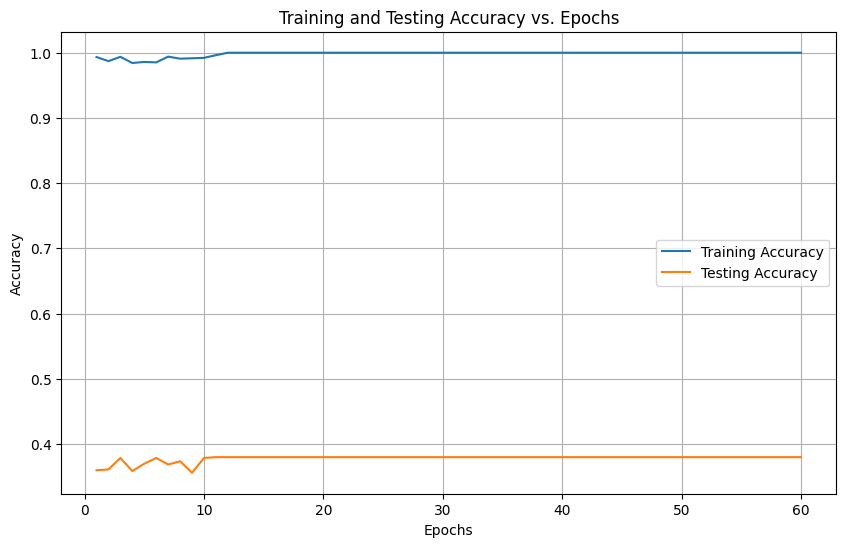

In [5]:
def manual_perceptron_train_with_metrics(X_train, Y_train, X_test, Y_test, weights, bias, learning_rate, max_epochs):
    training_accuracies = []
    testing_accuracies = []
    
    for epoch in range(max_epochs):
        correct_predictions = 0
        for i in range(X_train.shape[0]):
            xi = X_train[i]
            yi = Y_train[i]
            
            output = np.dot(xi, weights) + bias
            predicted_label = np.argmax(output)
            
            if predicted_label == yi:
                correct_predictions += 1
            
            if predicted_label != yi:
                weights[:, yi] += learning_rate * xi  
                weights[:, predicted_label] -= learning_rate * xi 
                bias[yi] += learning_rate 
                bias[predicted_label] -= learning_rate
    
        training_accuracy = correct_predictions / X_train.shape[0]
        training_accuracies.append(training_accuracy)
        
        y_test_pred = manual_perceptron_predict(X_test, weights, bias)
        test_accuracy = np.mean(y_test_pred == Y_test)
        testing_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch + 1}/{max_epochs} - Training Accuracy: {training_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")
    
    return weights, bias, training_accuracies, testing_accuracies

weights, bias, training_accuracies, testing_accuracies = manual_perceptron_train_with_metrics(
    X_train_scaled, y_train, X_test_scaled, y_test, weights, bias, learning_rate, max_epochs
)

#plot
plt.figure(figsize=(10, 6))
epochs = range(1, max_epochs + 1)
plt.plot(epochs, training_accuracies, label='Training Accuracy')
plt.plot(epochs, testing_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()
